# Titanic Dataset Training with GP

### General Useful Packages:
- **numpy**: Provides support for large, multi-dimensional arrays and matrices, and offers a collection of mathematical functions to operate on these arrays.
- **pandas**: A powerful data manipulation library for structured data, providing data frames for data storage and operations like filtering, aggregating, and merging.
- **random**: Implements pseudo-random number generators for various distributions, useful for random selections and simulations.
- **operator**: Provides functional equivalents to common Python operators, enabling cleaner and faster functional-style programming.
- **matplotlib.pyplot**: A plotting library for creating static, interactive, and animated visualizations in Python, particularly for 2D graphs.

### Preprocessing and Metrics:
- **sklearn.model_selection.train_test_split**: A function for splitting data into training and testing sets for machine learning tasks.
- **sklearn.metrics.accuracy_score**: A function for calculating the accuracy of a classification model, comparing predicted labels with the true labels.
- **sklearn.metrics.confusion_matrix**: A function for calculating the confusion matrix

### Genetic Programming Stuff:
- **deap.algorithms**: Contains various algorithms (e.g., genetic algorithm, evolutionary strategies) for optimization tasks.
- **deap.base**: Provides base classes and methods to build evolutionary algorithms, such as individuals, populations, and evolutionary operators.
- **deap.creator**: Allows the creation of custom classes (e.g., individuals, fitness) with inheritance from DEAP’s base classes.
- **deap.tools**: Offers a collection of tools for evolutionary computation, like selection, mutation, and crossover operators.
- **deap.gp**: Provides functionalities for Genetic Programming (GP), allowing tree-based structures for evolving expressions or solutions.

In [3]:
# General Useful Packages
import numpy as np
import pandas as pd
import random
import operator
import matplotlib.pyplot as plt

# Preprocessing and Metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score


# Genetic Programming Stuff
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

**Load and Preprocess the data**
- Load the training data from `train.csv`

- Drop: Name, Ticket, Cabin 

- Transform: (Sex-> Male:0, Female:1), (Embarked-> S:0, C:1, Q:2)

- N/A Values: Replace with Mean

In [4]:
# Load and preprocess the Titanic dataset
train_data = pd.read_csv("train.csv")
train_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)  # Drop unnecessary columns
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
train_data['Embarked'] = train_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
train_data.fillna(train_data.mean(), inplace=True)

**Declare Feature and Target Variables**
- Features = Pclass, Sex, Age, SibSp, Parch, Fare, Embarked
- Target = Survived

In [5]:
# Split features and target
X = train_data.drop(columns=['PassengerId', 'Survived']).values
y = train_data['Survived'].values

In [6]:
# KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=20)

# Set Up the Primitive Set
Defines the type of inputs and arguments

Create fitness and individual classes. The invidiual class inherits DEAP's PrimitiveTree class. This is the most common in GP Trees. They are made of functions and varaibles called primitives. Each primitive is a node in the ree where the leaves of a node are the inputs. Evaluate each invidiaul by compiling the pirmtiive tree from its leave to its root node.

In [7]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))  # Minimize FP, FN
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

Initialize the primitive set, add primitive operations (functions), and terminals (Titanic Features). Mathematical operators are added to our primitive set. I also rename the default arguments to the features that my titanic dataset uses.

In [8]:
# Initialize PrimitiveSet
pset = gp.PrimitiveSet("main", X.shape[1]) # X.shape[1] takes the number of features 

# Primitive Operations - Loosely Typed GP, no specific types
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(np.sin, 1)
pset.addPrimitive(np.cos, 1)
pset.addPrimitive(np.tan, 1) 
pset.addPrimitive(np.abs, 1)
pset.addEphemeralConstant("rand101_1", lambda: random.randint(-1, 1)) 

# Arguments: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked 
pset.renameArguments(ARG0="Pclass")
pset.renameArguments(ARG1="Sex")
pset.renameArguments(ARG2="Age")
pset.renameArguments(ARG3="SibSp")
pset.renameArguments(ARG4="Parch")
pset.renameArguments(ARG5="Fare")
pset.renameArguments(ARG6="Embarked")



Define the toolbox, individual, population, and compiler 

In [9]:
# Define Tool Box
toolbox = base.Toolbox()
# Register expressions, individuals, and populations in the toolbox
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


# Fitness evaluation function
def evaluate_individual(individual, data, target):
    func = toolbox.compile(expr=individual)
    predictions = [int(func(*row) > 0.5) for row in data]
    
    tn, fp, fn, tp = confusion_matrix(target, predictions).ravel()
    
    # Return both FP and FN for multi-objective optimization
    return fp, fn  # Tuple: (FP, FN)

# Register the evaluation function for multi-objective optimization
toolbox.register("evaluate", evaluate_individual)
toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)

# Algorihtm Parameters
POP_SIZE = 500
NGEN = 50
CXPB = 0.5 # crossover probability
MUTPB = 0.05 # mutation probability



# Pareto Frontier
- Loop through each individual pareto front and store FP and FN values after predicting on y_pred
- Plot after finishing loop

- Load and Preprocess Test Data (same preprocessing as train.csv)
- Compile the best individual (based on Pareto front)
- Make predictions using the best individual
- Output to CSV File

Fold 1 Accuracy: 83.24%
False Positives (FP): 9, False Negatives (FN): 21
Fold 2 Accuracy: 74.16%
False Positives (FP): 24, False Negatives (FN): 22
Fold 3 Accuracy: 78.09%
False Positives (FP): 12, False Negatives (FN): 27
Fold 4 Accuracy: 76.97%
False Positives (FP): 20, False Negatives (FN): 21
Fold 5 Accuracy: 80.90%
False Positives (FP): 16, False Negatives (FN): 18

Average Accuracy across folds: 78.67%


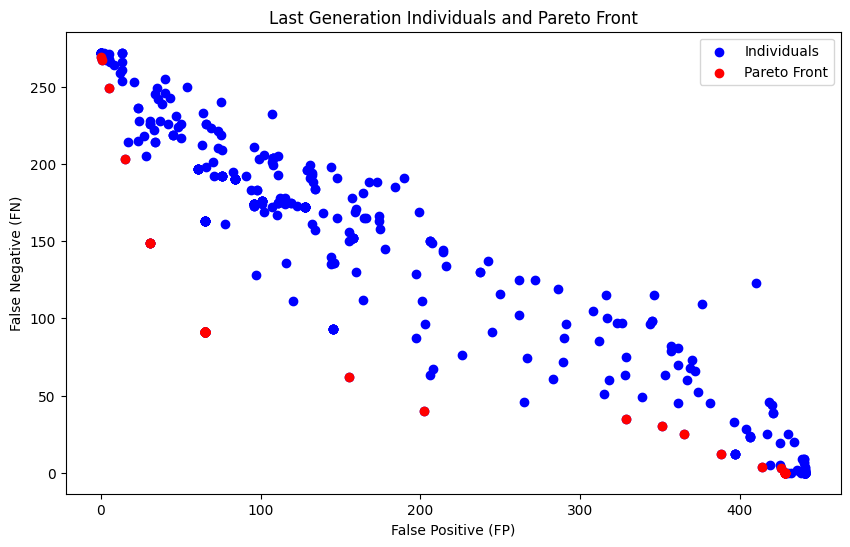


Best Individual: mul(tan(Sex), Sex)


In [16]:
# List to store values
fold_accuracies = []
pareto_fronts = []
best_individuals = [] 

# Perform KFold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Setup GP population
    population = toolbox.population(n=POP_SIZE)
    hall_of_fame = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Evolutionary Algorithm for NGEN generations
    for g in range(NGEN):
        offspring = tools.selNSGA2(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
                
        # Apply mutation
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = [toolbox.evaluate(ind, X_train_fold, y_train_fold) for ind in invalid_ind]
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the old population with the offspring
        population[:] = offspring

        # Collect the Pareto front for this generation
        pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]
        pareto_fronts.append(pareto_front)

    # Record the best individual from the Pareto front for this fold
    best_individual = pareto_fronts[-1][0]
    best_function = toolbox.compile(expr=best_individual)
    best_individuals.append(best_individual)

    # Evaluate the best individual on the test fold
    y_pred = [int(best_function(*row) > 0.5) for row in X_test_fold]

    # Calculate accuracy for the current fold
    accuracy = accuracy_score(y_test_fold, y_pred)
    fold_accuracies.append(accuracy)

    # Print results for this fold
    print(f"Fold {fold + 1} Accuracy: {accuracy * 100:.2f}%")
    tn, fp, fn, tp = confusion_matrix(y_test_fold, y_pred).ravel()
    print(f"False Positives (FP): {fp}, False Negatives (FN): {fn}")

# Final Results
print(f"\nAverage Accuracy across folds: {np.mean(fold_accuracies) * 100:.2f}%")

# Plotting the individuals of the last generation
last_generation = population  # Last generation after all evolutions
pareto_front_last_gen = tools.sortNondominated(last_generation, len(last_generation), first_front_only=True)[0]

# Extracting fitness values for plotting
fitnesses = [ind.fitness.values for ind in last_generation]
pareto_fitnesses = [ind.fitness.values for ind in pareto_front_last_gen]

# Scatter plot
plt.figure(figsize=(10, 6))

# Plot all individuals (in blue)
plt.scatter([f[0] for f in fitnesses], [f[1] for f in fitnesses], c='blue', label="Individuals")

# Highlight Pareto front individuals (in red)
plt.scatter([f[0] for f in pareto_fitnesses], [f[1] for f in pareto_fitnesses], c='red', label="Pareto Front")

plt.title('Last Generation Individuals and Pareto Front')
plt.xlabel('False Positive (FP)')
plt.ylabel('False Negative (FN)')
plt.legend()
plt.show()

# Output the best individual and its function
best_individual_final = best_individuals[-1]
best_function_final = toolbox.compile(expr=best_individual_final)
print(f"\nBest Individual: {best_individual_final}")

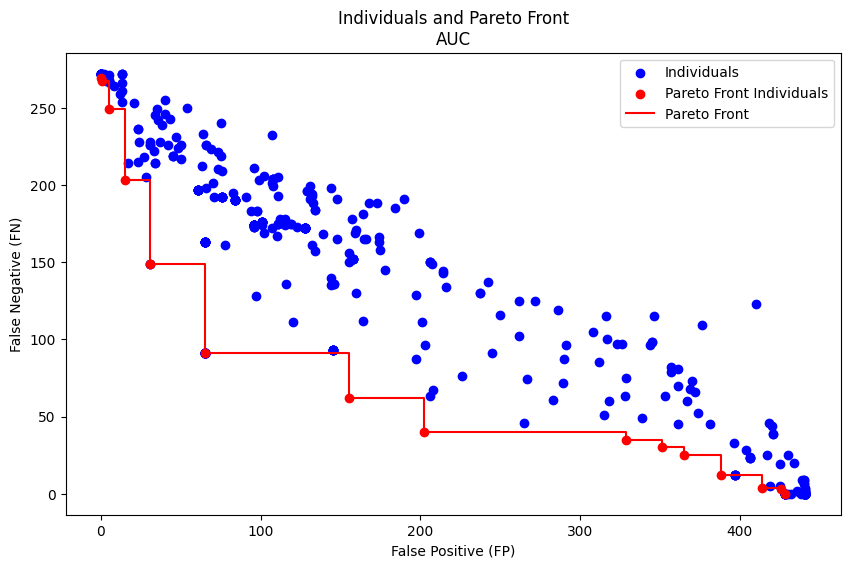

30456.0


In [17]:
# Function to find Pareto front from given data points
def find_pareto(data):
    is_Pareto = np.ones(data.shape[0], dtype=bool)
    for i, c in enumerate(data):
        if is_Pareto[i]:
            # Minimization (change to maximization if needed)
            is_Pareto[is_Pareto] = np.any(data[is_Pareto] < c, axis=1)

            # Keep the current point in the Pareto front
            is_Pareto[i] = True  

    # Downsample from boolean array
    Pareto_data = data[is_Pareto, :]

    # Sort data
    Pareto_out = Pareto_data[np.argsort(Pareto_data[:, 0])]

    return Pareto_out, is_Pareto

# Collect fitnesses for the last generation
fitnesses = np.array([ind.fitness.values for ind in last_generation])

# Use find_pareto to get the Pareto front points and the Pareto mask
pareto_front_data, pareto_mask = find_pareto(fitnesses)

# Calculate Area under the Pareto curve (AUC)
auc = np.sum(np.diff(pareto_front_data[:, 0]) * pareto_front_data[:-1, 1])

# Plotting the last generation individuals and the Pareto front
plt.figure(figsize=(10, 6))

# Plot all individuals that are not on the Pareto front (in blue)
plt.scatter(fitnesses[~pareto_mask, 0], fitnesses[~pareto_mask, 1], c='blue', label="Individuals")

# Plot Pareto front individuals (in red)
plt.scatter(fitnesses[pareto_mask, 0], fitnesses[pareto_mask, 1], c='red', label="Pareto Front Individuals")

# Plot the Pareto front as a step plot (in red)
plt.step(pareto_front_data[:, 0], pareto_front_data[:, 1], where='post', color='red', label="Pareto Front")

# Add labels and title
plt.title(f'Individuals and Pareto Front\nAUC')
plt.xlabel('False Positive (FP)')
plt.ylabel('False Negative (FN)')
plt.legend()

# Show the plot
plt.show()

print(auc)

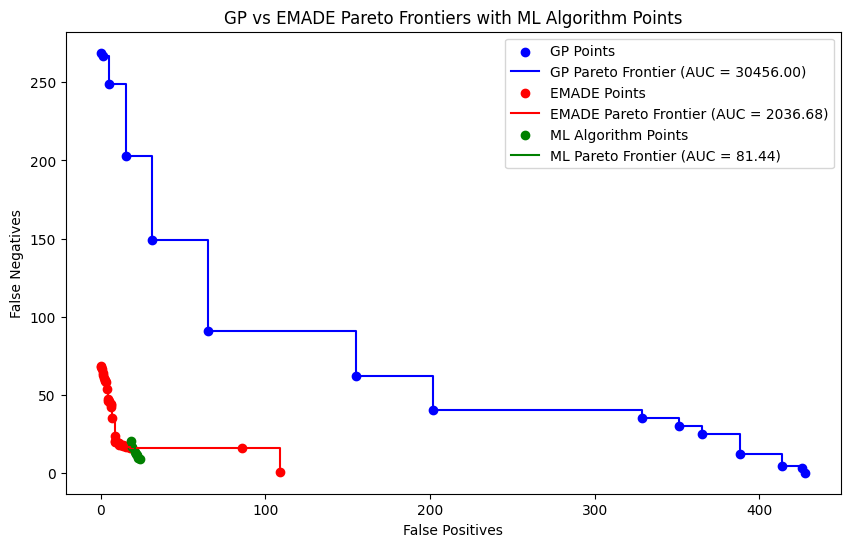

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML algorithm data
data_ml = {
    'KNN w/ 3N': (19, 16.6),
    'KNN w/ 5N': (20.6, 13.4),
    'KNN w/ 7N': (21.4, 12.2),
    'KNN w/ 8N': (23.6, 8.6),
    'KNN w/ 9N': (21.8, 11.6),
    'KNN w/ 10N': (22.8, 9.6),
    'Naive Bayes': (18, 20)
}

# Extract False Positives and False Negatives from the ML algorithms
ml_fp = [value[0] for value in data_ml.values()]
ml_fn = [value[1] for value in data_ml.values()]
ml_labels = list(data_ml.keys())

# Combine ML data into a single array for pareto calculation
data_ml_arr = np.column_stack((ml_fp, ml_fn))

# Pareto frontier calculation function
def find_pareto(data):
    is_Pareto = np.ones(data.shape[0], dtype=bool)
    for i, c in enumerate(data):
        if is_Pareto[i]:
            is_Pareto[is_Pareto] = np.any(data[is_Pareto] < c, axis=1)
            is_Pareto[i] = True
    Pareto_data = data[is_Pareto, :]
    Pareto_out = Pareto_data[np.argsort(Pareto_data[:, 0])]
    return Pareto_out, is_Pareto

# Find Pareto fronts for ML algorithms
pareto_front_ml, pareto_mask_ml = find_pareto(data_ml_arr)

# Calculate AUC for ML
auc_ml = np.sum(np.diff(pareto_front_ml[:, 0]) * pareto_front_ml[:-1, 1])

# Assuming EMADE data is loaded separately
file_path_emade = '/Users/wesleylu/Desktop/Fall-2024-Notes/VIP/Kaggle Titanic Competition/emade/pareto_front_across_all_generations.csv'
df_emade = pd.read_csv(file_path_emade)

# Extract the False Positives and False Negatives columns for EMADE
fp_emade = df_emade['FullDataSet False Positives'].values
fn_emade = df_emade['FullDataSet False Negatives'].values

# Combine EMADE columns into a single array for pareto calculation
data_emade = np.column_stack((fp_emade, fn_emade))

# Find Pareto fronts for EMADE
pareto_front_emade, pareto_mask_emade = find_pareto(data_emade)

# Calculate AUC for EMADE
auc_emade = np.sum(np.diff(pareto_front_emade[:, 0]) * pareto_front_emade[:-1, 1])

# Now for GP, assuming pareto_fronts contains Pareto fronts across generations for GP
# The pareto_fronts list stores the Pareto front individuals from each generation
# Extract the last generation's Pareto front for GP comparison
last_generation_gp = pareto_fronts[-1]  # The last generation Pareto front from GP
gp_fp = [ind.fitness.values[0] for ind in last_generation_gp]  # Extract False Positives (FP)
gp_fn = [ind.fitness.values[1] for ind in last_generation_gp]  # Extract False Negatives (FN)

# Combine GP columns into a single array for pareto calculation
data_gp = np.column_stack((gp_fp, gp_fn))

# Find Pareto front for GP from the last generation individuals
pareto_front_gp, pareto_mask_gp = find_pareto(data_gp)

# Calculate AUC for GP
auc_gp = np.sum(np.diff(pareto_front_gp[:, 0]) * pareto_front_gp[:-1, 1])

# Plotting the results for GP, EMADE, and ML algorithms
plt.figure(figsize=(10, 6))

# Plot GP individuals and Pareto front
plt.scatter(np.array(gp_fp)[pareto_mask_gp], np.array(gp_fn)[pareto_mask_gp], color='blue', label='GP Points')
plt.step(pareto_front_gp[:, 0], pareto_front_gp[:, 1], where='post', color='blue', label=f'GP Pareto Frontier (AUC = {auc_gp:.2f})')

# Plot EMADE individuals and Pareto front
plt.scatter(fp_emade[pareto_mask_emade], fn_emade[pareto_mask_emade], color='red', label='EMADE Points')
plt.step(pareto_front_emade[:, 0], pareto_front_emade[:, 1], where='post', color='red', label=f'EMADE Pareto Frontier (AUC = {auc_emade:.2f})')

# Plot ML algorithm points and Pareto front
plt.scatter(ml_fp, ml_fn, color='green', label='ML Algorithm Points')
plt.step(pareto_front_ml[:, 0], pareto_front_ml[:, 1], where='post', color='green', label=f'ML Pareto Frontier (AUC = {auc_ml:.2f})')

# Label the plot
plt.xlabel('False Positives')
plt.ylabel('False Negatives')
plt.title('GP vs EMADE vs ML Pareto Frontiers')
plt.legend()

# Show the plot
plt.show()


